# A Time Series Regression Analysis

## `Business Understanding`

`Project Description:`The goal of this project is to develop a time series regression model to accurately predict the unit sales of various items sold at Corporation Favorita's stores across different locations in Ecuador. The model aims to optimize inventory management by forecasting future demand, enabling the company to maintain optimal stock levels and minimize both overstocking and understocking situations. By leveraging historical sales data along with additional features such as promotional status, store information, and product details, the model will provide actionable insights to aid in strategic decision-making and improve overall operational efficiency.

### `Hypothesis`
`Null:` There is no significant relationship between the promotional status of products and the sales numbers within Corporation Favorita's stores

`Alternative:` There is a significant relationship between promotional status of products and the sales numbers within Corporation Favorita's stores

### `Research Questions`
1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

4. Did the earthquake impact sales?

5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

6. Are sales affected by promotions, oil prices and holidays?

7. What analysis can we get from the date and its extractable features?

8. Which product family and stores did the promotions affect.

9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## `Data Understanding`

### Import necessary packages

In [217]:
import pyodbc
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from itertools import product
import random 
import os
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle

from scipy.stats import ttest_ind
import plotly.express as px
pd.options.display.float_format = '{:.2f}'.format

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')
print("Activated")

Activated


In [218]:
# Load environment variables from .env file
load_dotenv()
 
# Access environment variables
db_server = os.getenv("DB_SERVER")
db_login = os.getenv("DB_LOGIN")
db_password = os.getenv("DB_PASSWORD")
db_name = os.getenv("DB_NAME")
 
# Connection string
connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={db_server};DATABASE={db_name};UID={db_login};PWD={db_password}"
 

In [219]:
# Connect to the database
connection = pyodbc.connect(connection_string)

### Load Datasets

In [220]:
# Write query to access table from the database
query_1 = "SELECT * FROM dbo.oil"

# Read data from SQL into a pandas DataFrame
oil_data = pd.read_sql(query_1, connection)

# Display first 5 rows of dataset
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [221]:
# Write query to access table from the database
query_2 = "SELECT * FROM dbo.holidays_events"

# Read data from SQL into a pandas DataFrame
holidays_data = pd.read_sql(query_2, connection)

# Display first 5 rows of dataset
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [222]:
# Write query to access table from the database
query_3 = "SELECT * FROM dbo.stores"

# Read data from SQL into a pandas DataFrame
stores_data = pd.read_sql(query_3, connection)

# Display first 5 rows of dataset
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [223]:
trans_data = pd.read_csv(r".\Data\transactions.csv",index_col="date",parse_dates=["date"])

trans_data.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


In [224]:
train_data = pd.read_csv(r'../Data/train.csv',index_col="date",parse_dates=["date"])

train_data.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.00,0
2013-01-01,1,1,BABY CARE,0.00,0
2013-01-01,2,1,BEAUTY,0.00,0
2013-01-01,3,1,BEVERAGES,0.00,0
2013-01-01,4,1,BOOKS,0.00,0


In [225]:
test_data = pd.read_csv(r'../Data/test.csv')

test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Data Inspection

In [226]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [227]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [228]:
oil_data.duplicated().sum()

0

In [229]:
holidays_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [230]:
holidays_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [231]:
holidays_data.duplicated().sum()

0

In [232]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [233]:
stores_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [234]:
stores_data.duplicated().sum()

0

In [235]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83488 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     83488 non-null  int64
 1   transactions  83488 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


In [236]:
trans_data.isnull().sum()

store_nbr       0
transactions    0
dtype: int64

In [237]:
trans_data.duplicated().sum()

45955

In [238]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [239]:
train_data.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [240]:
# Drop the id column 
train_data.drop(columns="id",inplace=True)

In [241]:
# Check the info about the DataFrame
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [242]:
train_data.duplicated().sum()

1985544

In [243]:
def convert_column_to_datetime_in_multiple_dfs(dfs, column_name):
    """
    Converts a specified column to datetime format in multiple DataFrames

    Parameters:
    dfs: List of DataFrames
    column_name (str): The name of the column to be converted

    Returns:
    List of DataFrames with the specified column converted to datetime.
    """
    converted_dfs = []
    for i, df in enumerate(dfs):
        try:
            df[column_name] = pd.to_datetime(df[column_name])
            print(f"Column '{column_name}' successfully converted to datetime in DataFrame {i}.")
        except Exception as e:
            print(f"An error occurred while converting column '{column_name}' to datetime in DataFrame {i}: {e}")
        converted_dfs.append(df)
    
    return converted_dfs

# List of DataFrames
dfs = [oil_data, holidays_data, trans_data, train_data, test_data]

# Convert 'date' column to datetime in all DataFrames
converted_dfs = convert_column_to_datetime_in_multiple_dfs(dfs, 'date')

# Print the converted DataFrames
for i, df in enumerate(converted_dfs):
    print(f"DataFrame {i}:\n{df}\n")


Column 'date' successfully converted to datetime in DataFrame 0.
Column 'date' successfully converted to datetime in DataFrame 1.
An error occurred while converting column 'date' to datetime in DataFrame 2: 'date'
An error occurred while converting column 'date' to datetime in DataFrame 3: 'date'
Column 'date' successfully converted to datetime in DataFrame 4.
DataFrame 0:
           date  dcoilwtico
0    2013-01-01         NaN
1    2013-01-02       93.14
2    2013-01-03       92.97
3    2013-01-04       93.12
4    2013-01-07       93.20
...         ...         ...
1213 2017-08-25       47.65
1214 2017-08-28       46.40
1215 2017-08-29       46.46
1216 2017-08-30       45.96
1217 2017-08-31       47.26

[1218 rows x 2 columns]

DataFrame 1:
          date        type    locale locale_name  \
0   2012-03-02     Holiday     Local       Manta   
1   2012-04-01     Holiday  Regional    Cotopaxi   
2   2012-04-12     Holiday     Local      Cuenca   
3   2012-04-14     Holiday     Local    L

Fill null walues in the oil dataset, 'dcoilwtico' (daily crude oil prices) column with the mean

In [244]:
oil_data['dcoilwtico'].fillna(oil_data['dcoilwtico'].mean(), inplace=True)

oil_data.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

We utilized an inner merge to merge the datasets, ensuring that we operate on a cohesive dataset containing solely pertinent information common to all datasets' dates. This consolidation facilitates a more orderly and uniform analysis, particularly for time series forecasting, by sidestepping issues like missing values or incongruent timestamps in the final dataset.

Additionally, employing an inner merge guarantees that every data point in the resultant dataset aligns with identical timestamps. This uniform timestamping establishes a cohesive time index crucial for analysis and modeling endeavors, promoting consistency and accuracy throughout.

#### Check for Completeness of Data

In [245]:
start_date = train_data.index.min()
end_date = train_data.index.max()

print(f"Start date is {start_date}")
print(f"End date is {end_date}")

Start date is 2013-01-01 00:00:00
End date is 2017-08-15 00:00:00


In [246]:
# check for date range
date_range = pd.date_range(start=start_date,end=end_date,freq="D")
print("The train dataset is not complete for all required dates. Missing dates:")
date_range

The train dataset is not complete for all required dates. Missing dates:


DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [247]:
# check for missing date
existing_dates = train_data.index
missing_dates = date_range.difference(existing_dates)
print("The following dates were missing") 
missing_dates

The following dates were missing


DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [248]:
# Filling missing dates With the Family Column

# check for unique values in the family column
families = train_data["family"].unique()

print(f"The unique product family in the table are {families.size}")
families

The unique product family in the table are 33


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [249]:
# check for unique stores in the store_nbr column
stores = train_data["store_nbr"].unique()

print(f"The unique number of stores in the table are {stores.size}")
stores

The unique number of stores in the table are 54


array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [250]:
# Create New Data points for the missing dates
missing_data = product(missing_dates,stores,families)

# Create a DataFrame for the missing data
missing_df = pd.DataFrame(data=missing_data,columns=["date","store_nbr","family"])
missing_df.set_index("date",inplace=True)
missing_df

,store_nbr,family
date,,
2013-12-25,1,AUTOMOTIVE
2013-12-25,1,BABY CARE
2013-12-25,1,BEAUTY
2013-12-25,1,BEVERAGES
2013-12-25,1,BOOKS
...,...,...
2016-12-25,9,POULTRY
2016-12-25,9,PREPARED FOODS
2016-12-25,9,PRODUCE


# check for the shape of the missing data

In [251]:
missing_df.shape

(7128, 2)

In [252]:
# Concatenate train_df to missing_df
final_train_data = pd.concat([train_data,missing_df],axis=0)
final_train_data

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00
2013-01-01,1,BABY CARE,0.00,0.00
2013-01-01,1,BEAUTY,0.00,0.00
2013-01-01,1,BEVERAGES,0.00,0.00
2013-01-01,1,BOOKS,0.00,0.00
...,...,...,...,...
2016-12-25,9,POULTRY,NaN,NaN
2016-12-25,9,PREPARED FOODS,NaN,NaN
2016-12-25,9,PRODUCE,NaN,NaN


In [253]:
# Check for Nulls
final_train_data.isna().sum()

store_nbr         0
family            0
sales          7128
onpromotion    7128
dtype: int64

In [254]:
# Filling Null Values in the final_train_data
final_train_data["sales"].fillna(0,inplace=True)
final_train_data["onpromotion"].fillna(0,inplace=True)


In [255]:

# check the shape of the final_train_df
final_train_data.shape


(3008016, 4)

In [256]:
# confirm the filling of missing dates
existing_dates = final_train_data.index
missing_dates = date_range.difference(existing_dates)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [257]:
# Confirm changes after filling the Null Values
final_train_data.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

## Univariate, Multivariate and Bivariate Analysis

Sales Distribution

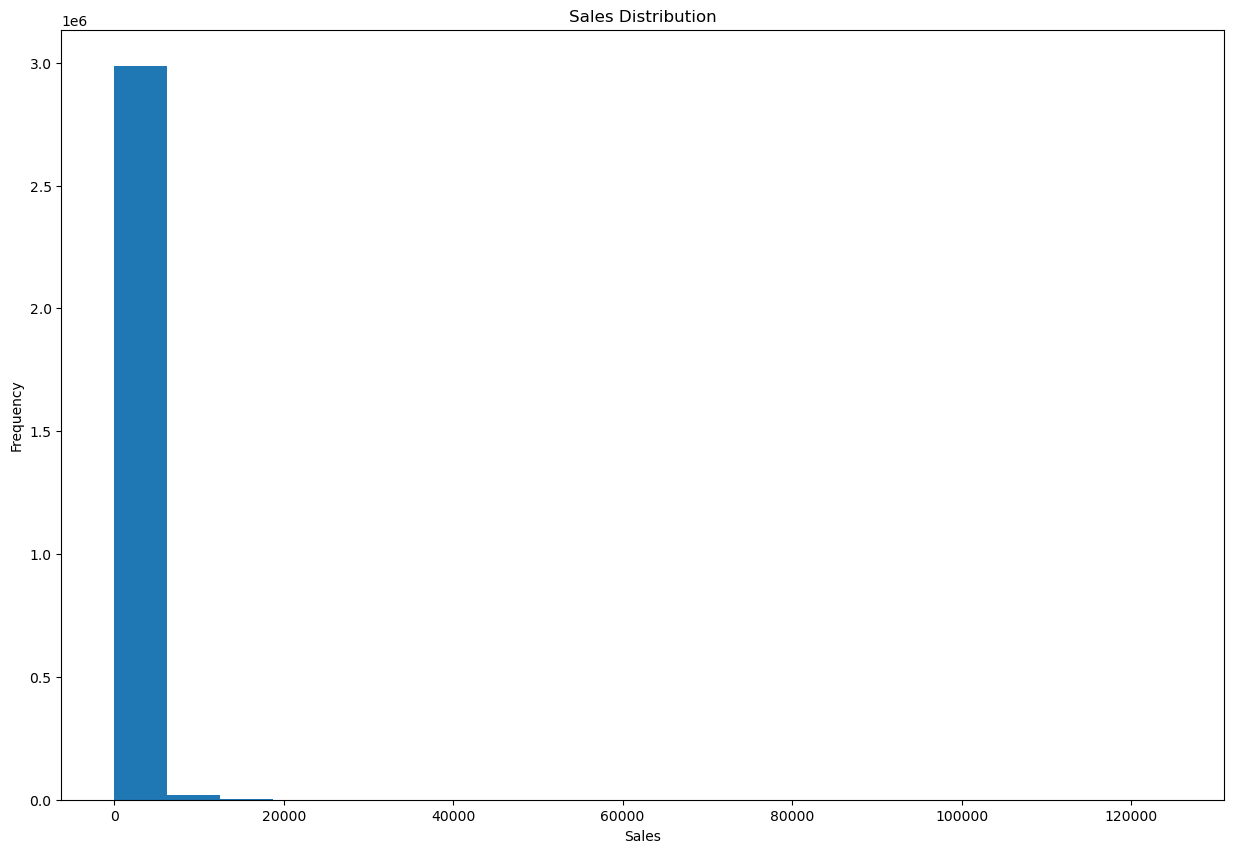

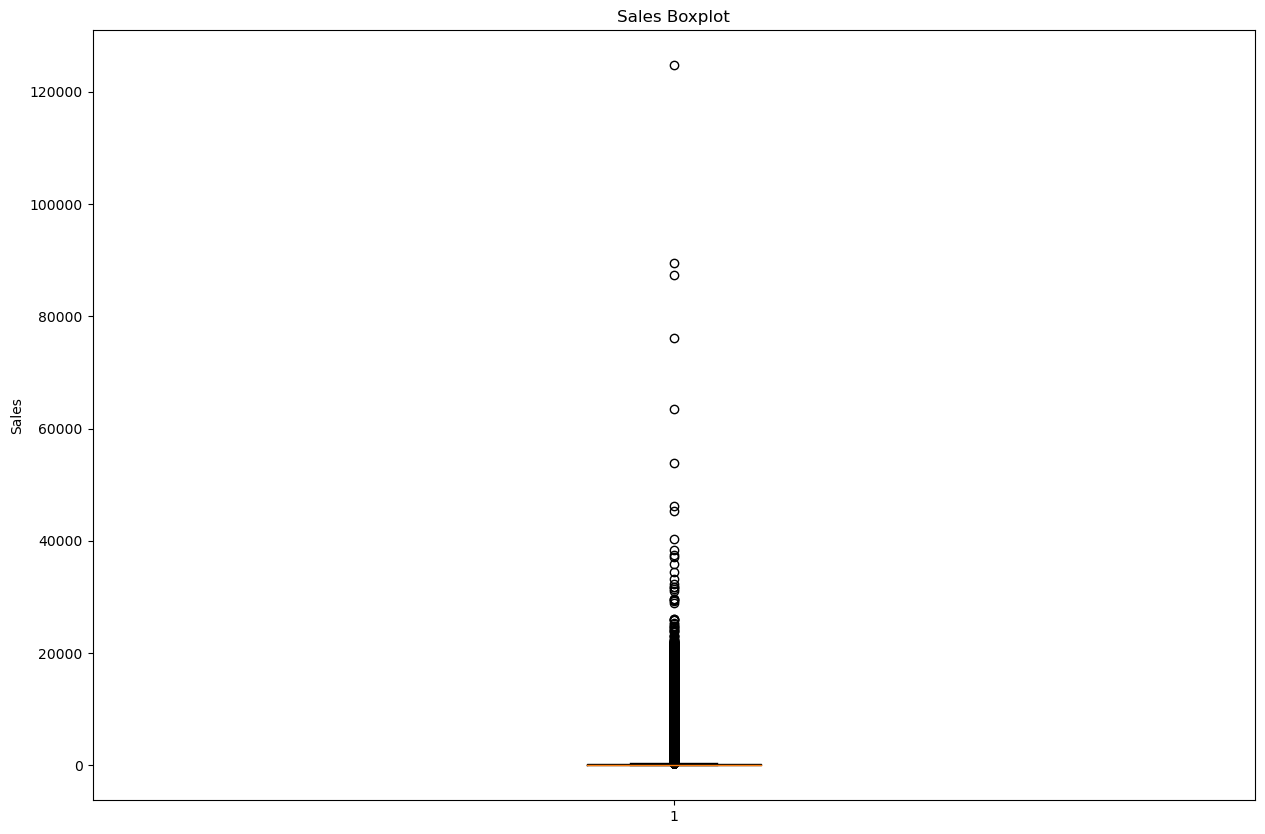

In [258]:
# Visualizing the distribution of sales with a histogram
plt.hist(final_train_data['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Sales Distribution')
plt.show()

# Creating a boxplot to display the spread of sales data
plt.boxplot(final_train_data['sales'])
plt.ylabel('Sales')
plt.title('Sales Boxplot')
plt.show()


The histogram provides insight into the frequency distribution of sales values, highlighting a predominant range where most sales occur, depicted by the peak in the histogram. Nonetheless, there are sporadic occurrences of higher sales values, resulting in a right-skewed distribution. This skewness indicates a scarcity of very high sales instances, with the majority of sales concentrated at lower values. The boxplot further corroborates the presence of outliers in the dataset, observed as points extending beyond the whiskers.

These outliers, identified by points beyond the whiskers in the boxplot, denote instances of exceptionally high sales values that are largely different from normal sales. From a business standpoint, these outliers could signify significant transactions.

#### Density Plots

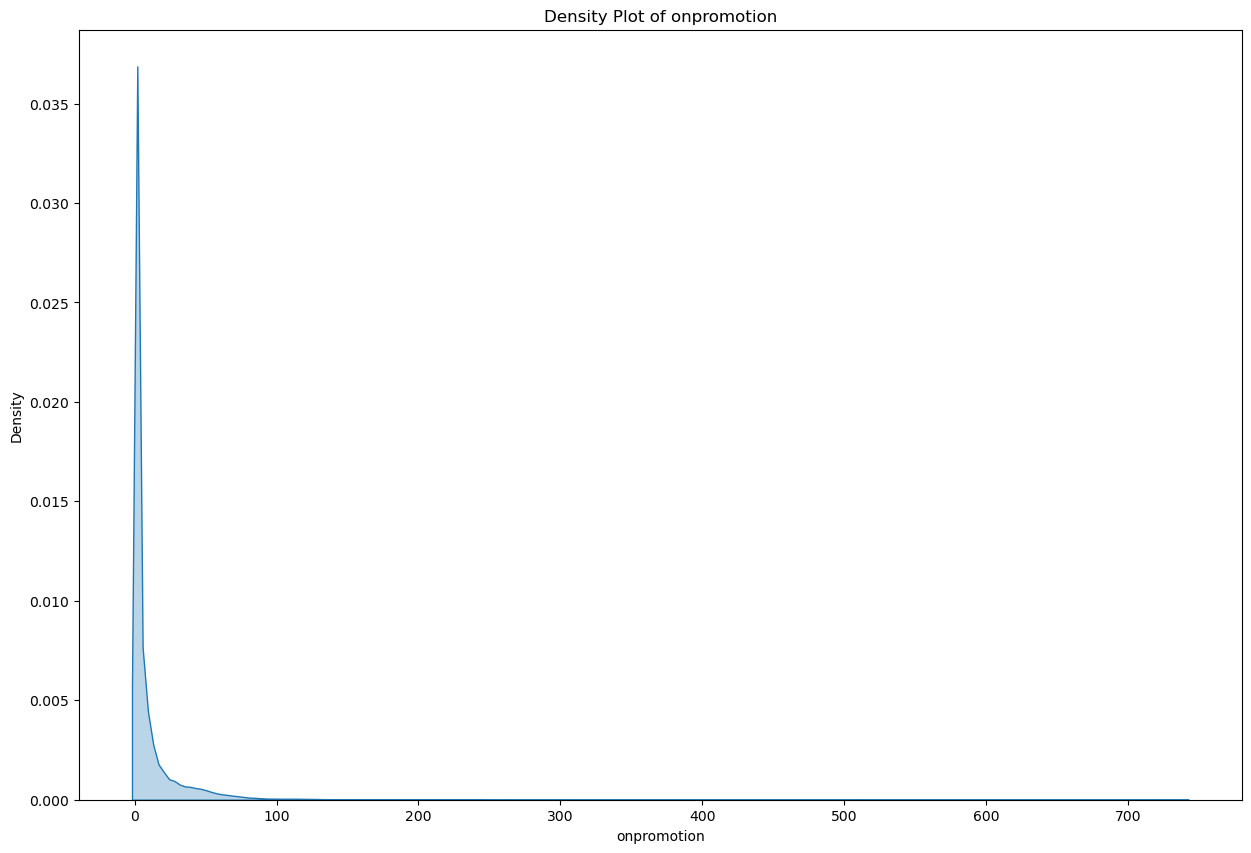

In [259]:
# KDE plot to visualize skewness of data
sns.kdeplot(final_train_data["onpromotion"],alpha=0.3,fill=True)
plt.title("Density Plot of onpromotion")
plt.show()

In [260]:
# check for skewness of data
numerical_columns = final_train_data.select_dtypes(include=["number"]).columns
skewness = train_data[numerical_columns].skew()
skewness

store_nbr      0.00
sales          7.36
onpromotion   11.17
dtype: float64

## Multivariate

In [261]:
# Create new features
def create_features(final_train_data):
  final_train_data["month_name"] = final_train_data.index.month_name()
  final_train_data["month"] =final_train_data.index.month
  final_train_data["year"] = final_train_data.index.year
  final_train_data["day"] = final_train_data.index.dayofweek
  final_train_data["day_name"] = final_train_data.index.day_name()
  final_train_data["day_of_month"] = final_train_data.index.day
  final_train_data["quarter"] =final_train_data.index.quarter
  return final_train_data
 
final_train_data = create_features(final_train_data)
final_train_data

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter
date,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,1,1
2013-01-01,1,BABY CARE,0.00,0.00,January,1,2013,1,Tuesday,1,1
2013-01-01,1,BEAUTY,0.00,0.00,January,1,2013,1,Tuesday,1,1
2013-01-01,1,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,1,1
2013-01-01,1,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-25,9,POULTRY,0.00,0.00,December,12,2016,6,Sunday,25,4
2016-12-25,9,PREPARED FOODS,0.00,0.00,December,12,2016,6,Sunday,25,4
2016-12-25,9,PRODUCE,0.00,0.00,December,12,2016,6,Sunday,25,4


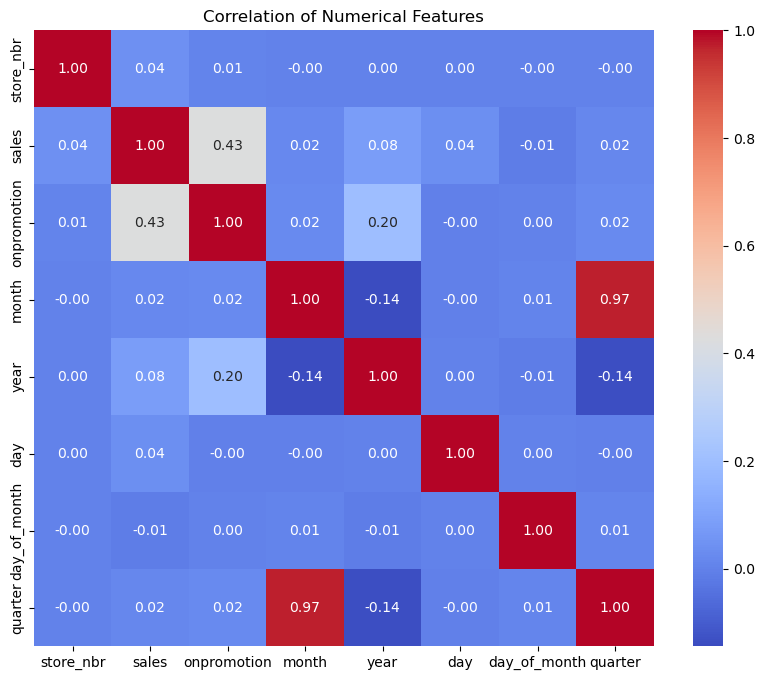

In [262]:
# Plot Heatmap To Visualize The Correlation of Features
correlation_matrix_with_date = final_train_data.drop(columns=["family","day_name","month_name"]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_with_date,annot=True, cmap='coolwarm',fmt=".2f")
plt.title("Correlation of Numerical Features")
plt.show()


### Decomposition

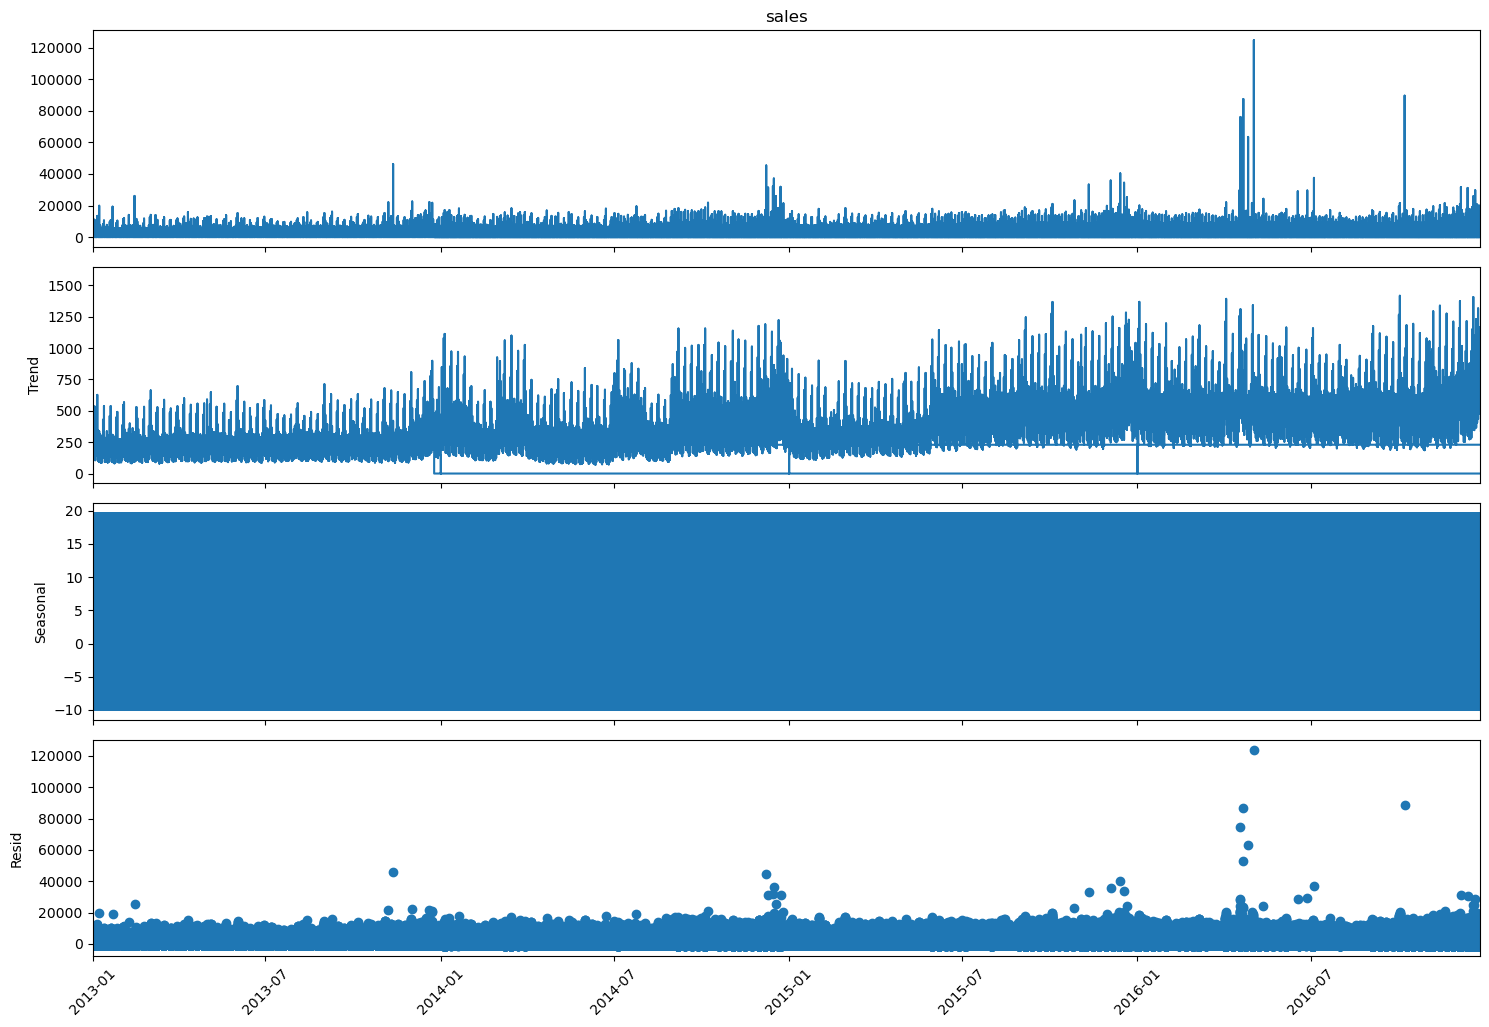

In [263]:
#check if the dataset has seasonality or not
# Decompose the column to be used for prediction('sales')

additive_result = seasonal_decompose(final_train_data["sales"],model="additive",period=365)
additive_result.plot()
plt.rcParams.update({'figure.figsize':(15,10)})
plt.xticks(rotation=45)
plt.show()

In [264]:
# Create a dataframe named decomposition_df
decomposition_df = pd.DataFrame({
    'Trend': additive_result.trend,
    'Seasonality':additive_result.seasonal,
    'Residual': additive_result.resid,
    'Observed': additive_result.observed,
})
decomposition_df

,Trend,Seasonality,Residual,Observed
date,,,,
2013-01-01,NaN,2.95,NaN,0.00
2013-01-01,NaN,2.19,NaN,0.00
2013-01-01,NaN,-0.18,NaN,0.00
2013-01-01,NaN,15.74,NaN,0.00
2013-01-01,NaN,-0.46,NaN,0.00
...,...,...,...,...
2016-12-25,NaN,0.56,NaN,0.00
2016-12-25,NaN,-3.57,NaN,0.00
2016-12-25,NaN,-0.32,NaN,0.00


## Stationarity Testing

In [265]:
# Resample and calculate the mean only on the sales column
df_downsampled = final_train_data[["sales"]].resample("W").mean()

# check if there are Null values and handle them
df_downsampled.fillna(0,inplace=True)
df_downsampled 
# Use Adfuller to check for stationarity
adftest = adfuller(df_downsampled["sales"])
print(f"ADF statistics: {adftest[0]}")
print(f"p-value: {adftest[1]}")
print(f"Critical values: {adftest[4]}")

if adftest[1] > 0.05:
    print("The series is non-stationary")
else:
    print("The series is stationary")

ADF statistics: -1.4817509177560264
p-value: 0.5425188110982642
Critical values: {'1%': -3.4593607492757554, '5%': -2.8743015807562924, '10%': -2.5735714042782396}
The series is non-stationary



CONCLUSION

We fail to reject the null hypothesis. The ADF test results indicate a non-stationary series since the p-value (0.5425) is greater than the typical significance level of 0.05, and the test statistic (-1.4818) is not less than the critical values at the 1%, 5%, and 10% significance levels. Therefore, the null hypothesis that the series has a unit root (is non-stationary) is not rejected.

## ANALYTICAL QUESTIONS

#### 1. Is the train dataset complete (has all the required dates)?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


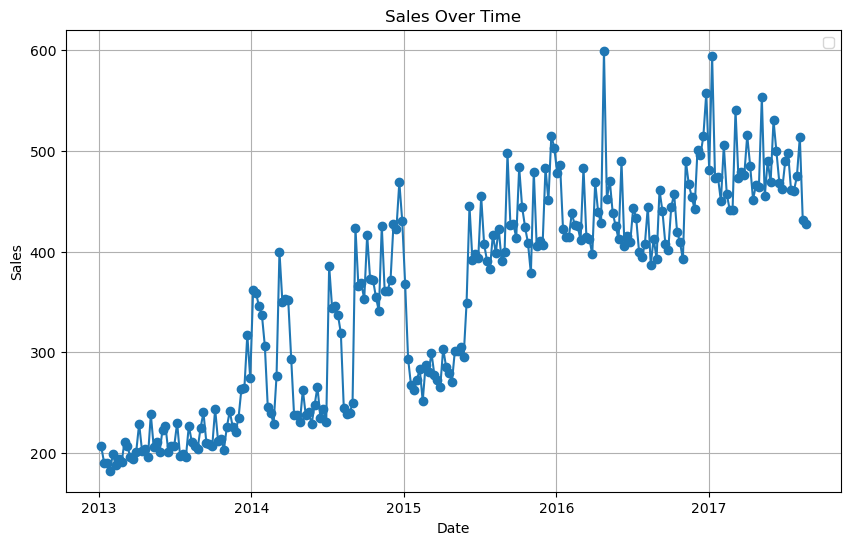

In [266]:
plt.figure(figsize=(10, 6))
plt.plot(df_downsampled.index, df_downsampled['sales'], marker='o', linestyle='-')

# Check for missing dates
missing_dates = df_downsampled[df_downsampled['sales'].isnull()].index
if len(missing_dates) > 0:
    plt.scatter(missing_dates, df_downsampled.loc[missing_dates, 'sales'], color='red', label='Missing Dates')

plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

#### 2. Which dates have the lowest and highest sales for each year?

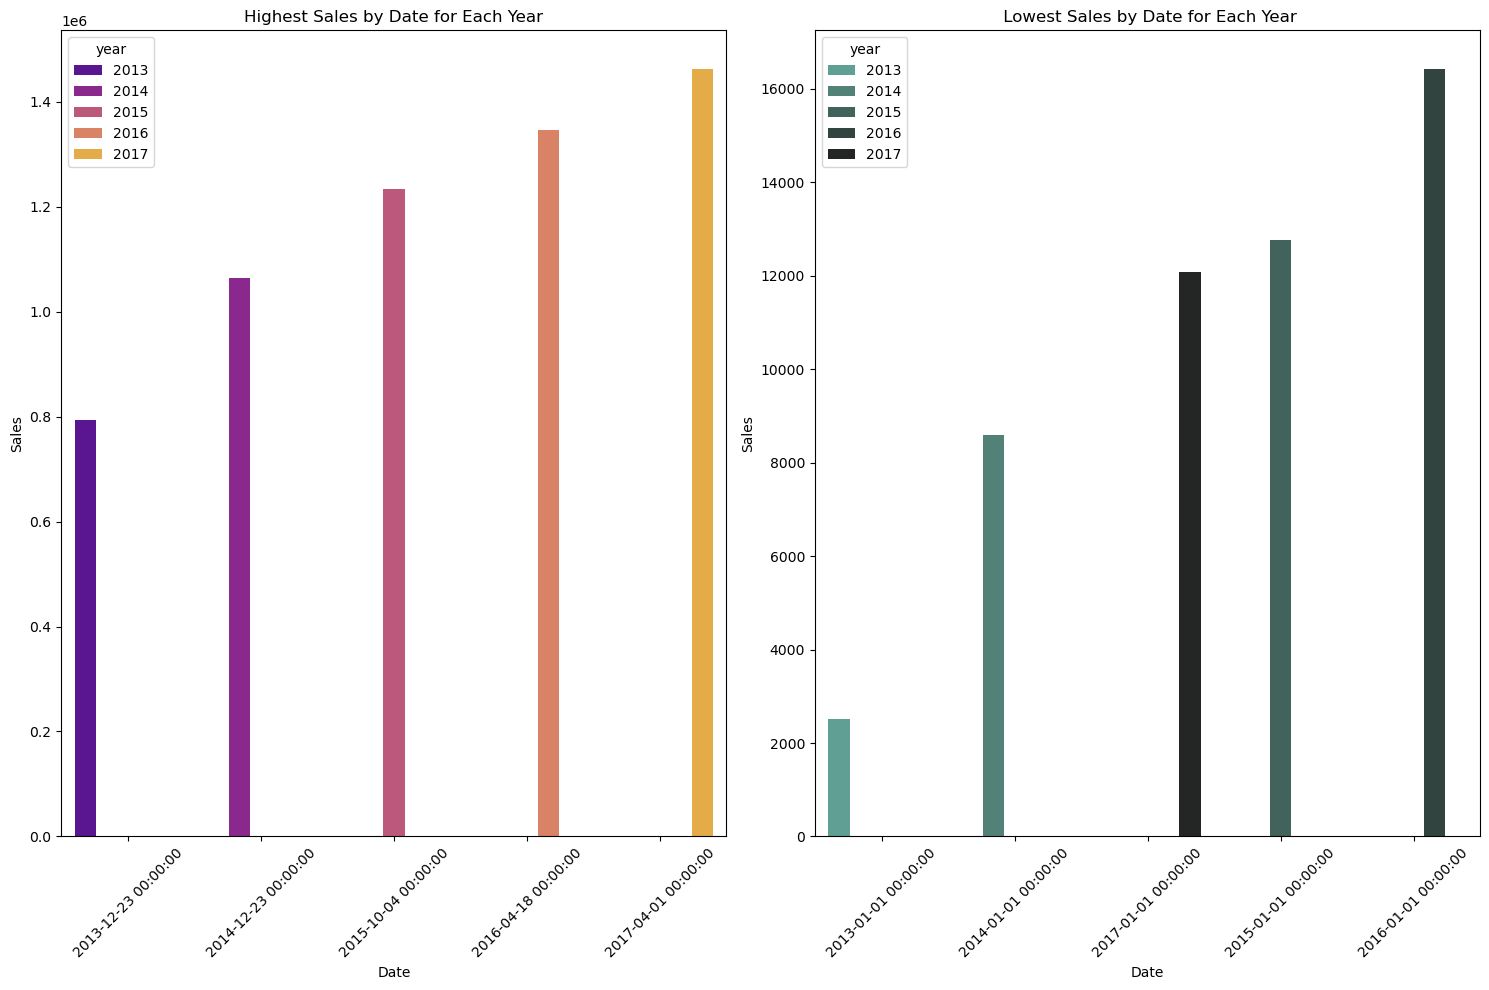

In [267]:
# filter days where the store wasn't opened
sum_of_sales =final_train_data.groupby(final_train_data.index)["sales"].sum()
active_days = final_train_data[sum_of_sales != 0 ]
# Find the highest and the lowest sales per yer from the active_days
sales_dist = active_days.groupby(by=[active_days.index.year,active_days.index])["sales"].sum().sort_values(ascending=True)

# Find the dates with the highest and lowest sales for each year
highest_sales = sales_dist.groupby(level=0).tail(1).reset_index(level=0)
lowest_sales = sales_dist.groupby(level=0).head(1).reset_index(level=0)

# Rename the index column
highest_sales.rename(columns={highest_sales.index.name: "year", "sales": "Sales_Highest"}, inplace=True)
lowest_sales.rename(columns={lowest_sales.index.name: "year", "sales": "Sales_Lowest"}, inplace=True)

# Plotting
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
sns.barplot(data=highest_sales,x=highest_sales.index, y=highest_sales["Sales_Highest"],hue="year",palette="plasma")
plt.title("Highest Sales by Date for Each Year")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1,2,2)
sns.barplot(data=lowest_sales,x=lowest_sales.index, y=lowest_sales["Sales_Lowest"],hue="year",palette="dark:#5A9_r")
plt.title(" Lowest Sales by Date for Each Year")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3. Compare the sales for each month across the years and determine which month of which year had the highest sales

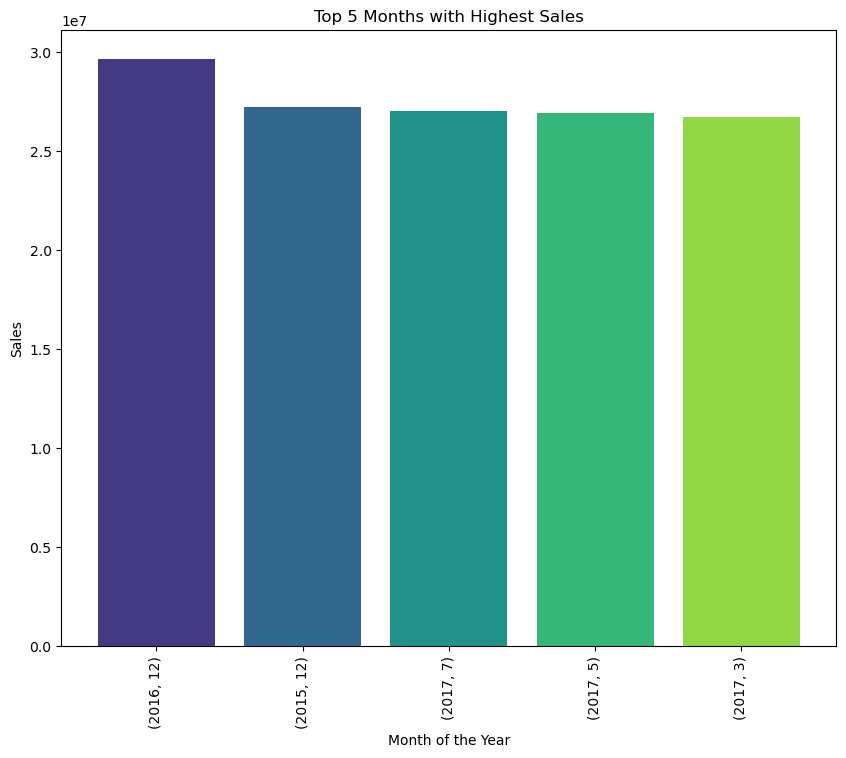

In [268]:
# Get the year from index
year = final_train_data.index.year
# Get month from index
month = final_train_data.index.month
# Group sales by year and month
sales_per_month = final_train_data.groupby([year,month])["sales"].sum().sort_values(ascending=False).head(5)


# Plotting
plt.figure(figsize=(10,8))
bar_width = 0.8
# Define your custom color palette
custom_palette = sns.color_palette("viridis", n_colors=5)
sales_per_month.plot(kind="bar",width=bar_width,color=custom_palette)
plt.title("Top 5 Months with Highest Sales")
plt.xlabel("Month of the Year")
plt.ylabel("Sales")
plt.show()

### 4.Did the earthquake impact sales?

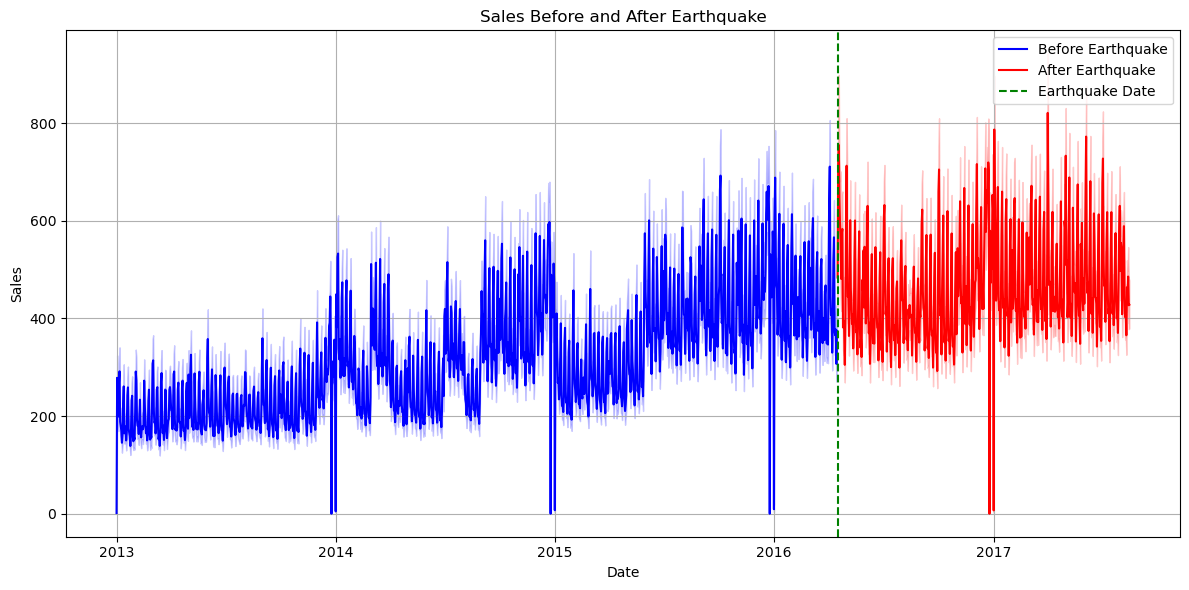

In [269]:
# Filter data for the period before and after the earthquake
earthquake_date = "2016-04-16"
post_earthquake = final_train_data[final_train_data.index >= earthquake_date]
pre_earthquake = final_train_data[final_train_data.index < earthquake_date]

plt.figure(figsize=(12,6))
# Spliting the data into pre and post-earthquake periods
sns.lineplot(data=pre_earthquake, x='date', y='sales', label='Before Earthquake', color='blue')
sns.lineplot(data=post_earthquake, x='date', y='sales', label='After Earthquake', color='red')

# Create a line plot to visualize sales before and after the earthquake
plt.axvline(pd.to_datetime(earthquake_date), color='green', linestyle='--', label='Earthquake Date')

plt.title("Sales Before and After Earthquake")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

In [270]:
# Merge the stores dataframe and the final_train_df
store_train_data = pd.merge(final_train_data,stores_data,on="store_nbr",how="inner")
store_train_data

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter,city,state,type,cluster
0,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
1,1,BABY CARE,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
2,1,BEAUTY,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
3,1,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
4,1,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,9,POULTRY,0.00,0.00,December,12,2016,6,Sunday,25,4,Quito,Pichincha,B,6
3008012,9,PREPARED FOODS,0.00,0.00,December,12,2016,6,Sunday,25,4,Quito,Pichincha,B,6
3008013,9,PRODUCE,0.00,0.00,December,12,2016,6,Sunday,25,4,Quito,Pichincha,B,6
3008014,9,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,December,12,2016,6,Sunday,25,4,Quito,Pichincha,B,6


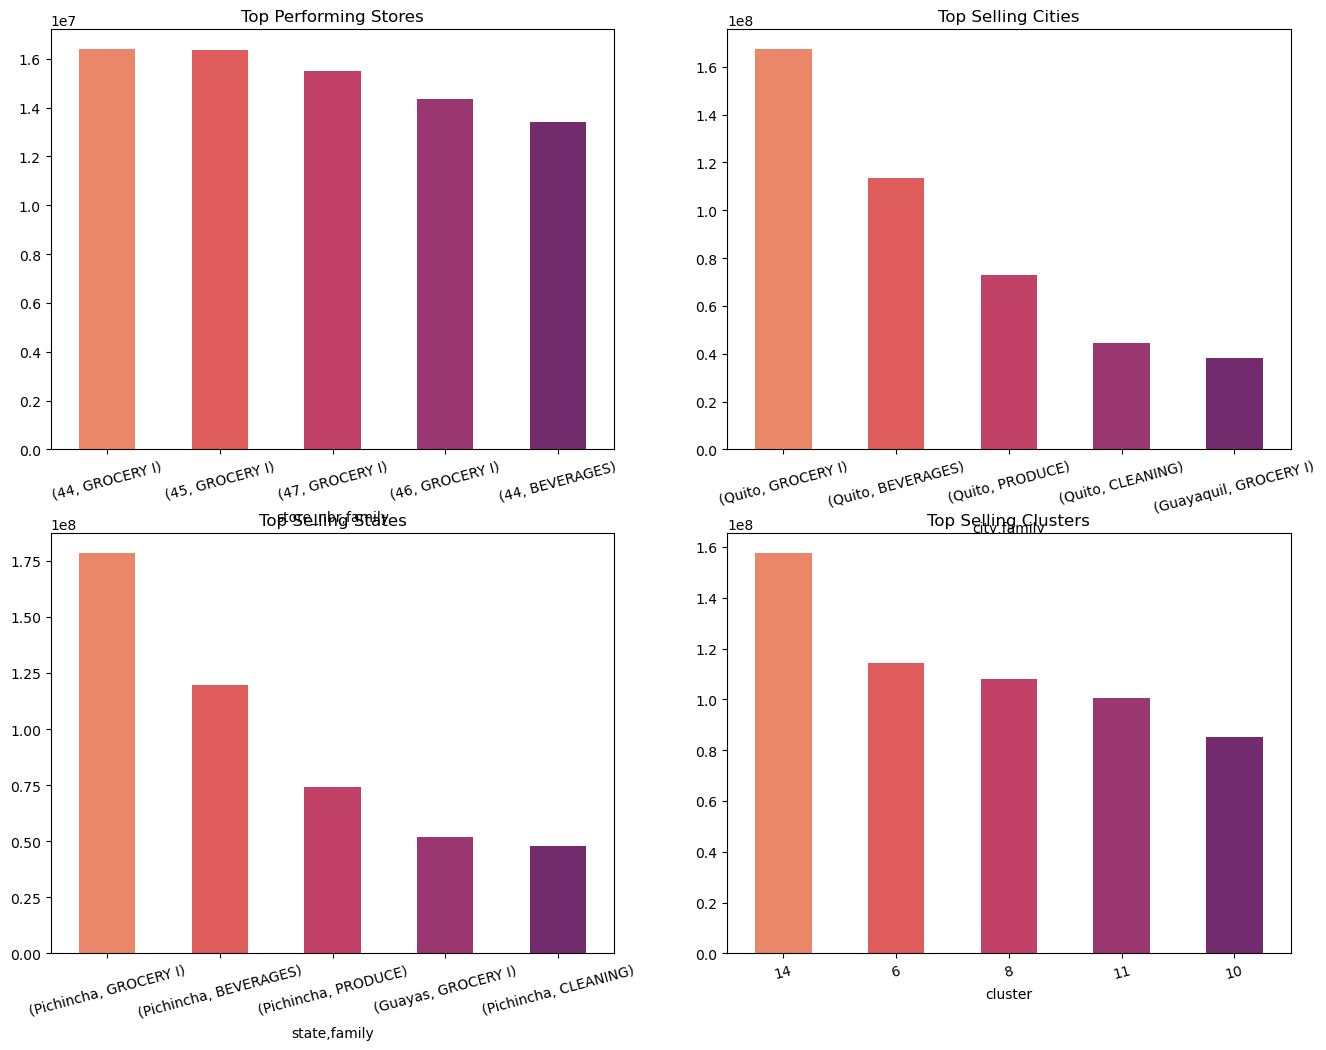

In [271]:
# Group stores by store number and sales
sales_by_stores = store_train_data.groupby(by=["store_nbr","family"])["sales"].sum().sort_values(ascending=False).head(5)
# Group stores by city, family of products and sales
sales_by_city =store_train_data.groupby(by=["city","family"])["sales"].sum().sort_values(ascending=False).head(5)

# Group stores by state, family of products and sales
sales_by_state = store_train_data.groupby(by=["state","family"])["sales"].sum().sort_values(ascending=False).head(5)
# Group stores by cluster, family of products and sales
sales_by_cluster= store_train_data.groupby(by=["cluster"])["sales"].sum().sort_values(ascending=False).head(5)

# Plotting
# Set the figure size for the subplot
plt.figure(figsize=(16,12))
# Define your custom color palette
custom_palette = sns.color_palette("flare", n_colors=5)

# Subplot 1
plt.subplot(2,2,1)
sales_by_stores.plot(kind="bar",color=custom_palette)
plt.title("Top Performing Stores")
plt.xticks(rotation=15)

# Subplot 2
plt.subplot(2,2,2)
sales_by_city.plot(kind="bar",color=custom_palette)
plt.title("Top Selling Cities")
plt.xticks(rotation=15)

# Subplot 3

plt.subplot(2,2,3)
sales_by_state.plot(kind="bar",color=custom_palette)
plt.title("Top Selling States")
plt.xticks(rotation=15)

# Subplot 4
plt.subplot(2,2,4)
sales_by_cluster.plot(kind="bar",color=custom_palette)
plt.title("Top Selling Clusters")
plt.xticks(rotation=15)
plt.show()

### 6.Are sales affected by promotions, oil prices and holidays?

#####  Effects of promotions on sales

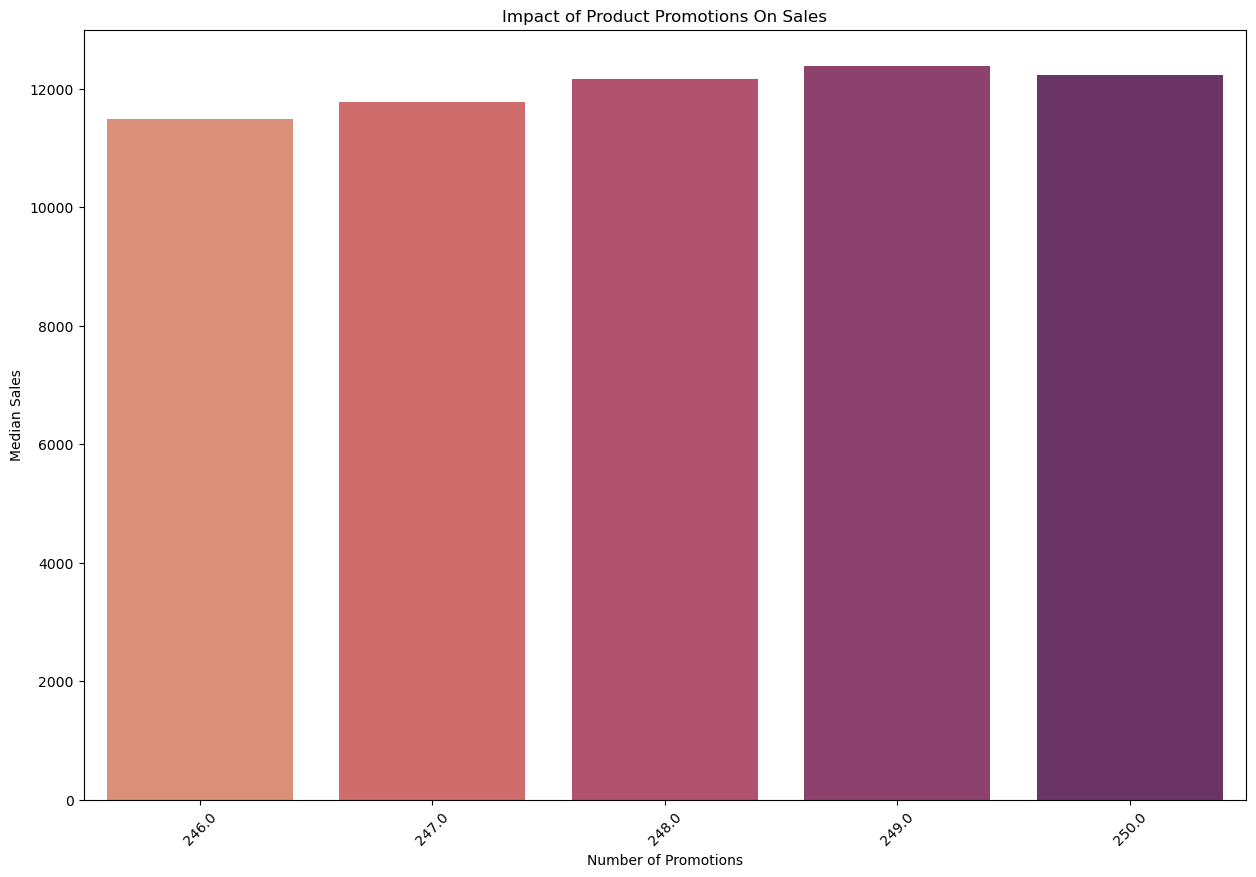

In [272]:
 # Check the effect of promotions on sales  
promo_sales = final_train_data.groupby(by="onpromotion")["sales"].median().sort_values(ascending=False).head(5)
# Convert promo_sales to DataFrame
promo_sales_df = pd.DataFrame(promo_sales).sort_values(by="sales", ascending=False)

# Plotting
sns.barplot(data=promo_sales_df,x=promo_sales_df.index, y="sales",palette="flare")
plt.title("Impact of Product Promotions On Sales")
plt.xlabel("Number of Promotions")
plt.ylabel("Median Sales")
plt.xticks(rotation=45)
plt.show()

##### Effects of Holidays on sales

In [273]:
# Convert the 'date' column in holiday_df to datetime
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Check the data types to ensure 'date' is converted to datetime
print(holidays_data.dtypes)

# Now, merge the datasets on the common column 'date'
holiday_train_df = pd.merge(final_train_data, holidays_data, on='date', how='inner')

# Check the merged DataFrame
print(holiday_train_df.tail())

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object
             date  store_nbr                      family  sales  onpromotion  \
509647 2016-12-25          9                     POULTRY   0.00         0.00   
509648 2016-12-25          9              PREPARED FOODS   0.00         0.00   
509649 2016-12-25          9                     PRODUCE   0.00         0.00   
509650 2016-12-25          9  SCHOOL AND OFFICE SUPPLIES   0.00         0.00   
509651 2016-12-25          9                     SEAFOOD   0.00         0.00   

       month_name  month  year  day day_name  day_of_month  quarter     type  \
509647   December     12  2016    6   Sunday            25        4  Holiday   
509648   December     12  2016    6   Sunday            25        4  Holiday   
509649   December     12  2016    6   Sunday            25        4  Holiday   
50965

Sales are lower on holidays compared to non-holidays.


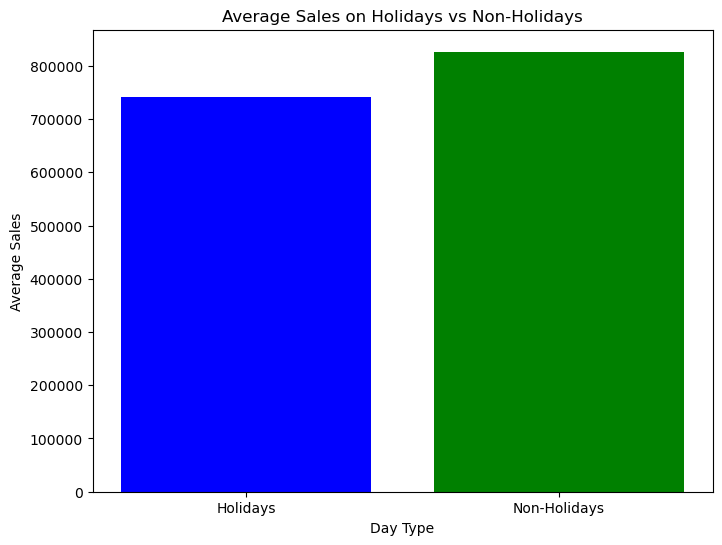

In [274]:
holiday_train_df['date'] = pd.to_datetime(holiday_train_df['date'])

# Group by date and sum the sales for each day
daily_sales =holiday_train_df .groupby('date')['sales'].sum().reset_index()

# Identify holidays based on the 'type' column
holidays = holiday_train_df[holiday_train_df['type'] == 'Holiday']['date'].dt.date.unique()

# Create a new column to mark whether a day is a holiday or not
daily_sales['is_holiday'] = daily_sales['date'].dt.date.isin(holidays)

# Calculate average sales on holidays and non-holidays
avg_sales_by_holiday = daily_sales[daily_sales['is_holiday']]['sales'].mean()
avg_sales_by_non_holiday = daily_sales[~daily_sales['is_holiday']]['sales'].mean()

# Compare average sales
if avg_sales_by_holiday > avg_sales_by_non_holiday:
    print("Sales are higher on holidays compared to non-holidays.")
elif avg_sales_by_holiday < avg_sales_by_non_holiday:
    print("Sales are lower on holidays compared to non-holidays.")
else:
    print("There is no significant difference in sales between holidays and non-holidays.")

# Create a bar plot to visualize the average sales
plt.figure(figsize=(8, 6))
plt.bar(['Holidays', 'Non-Holidays'], [avg_sales_by_holiday, avg_sales_by_non_holiday], color=['blue', 'green'])
plt.xlabel('Day Type')
plt.ylabel('Average Sales')
plt.title('Average Sales on Holidays vs Non-Holidays')
plt.show()

##### Effects of oil prices on Sales

In [275]:
# Convert the 'date' column in oil_df to datetime
oil_data['date'] = pd.to_datetime(oil_data['date'])

# Check the data types to ensure 'date' is converted to datetime
print(oil_data.dtypes)

# Now, merge the datasets on the common column 'date'
oil_train_df = pd.merge(final_train_data, oil_data, on='date', how='inner')

# Check the merged DataFrame
print(oil_train_df.tail())

date          datetime64[ns]
dcoilwtico           float64
dtype: object
              date  store_nbr                      family  sales  onpromotion  \
2149087 2015-12-25          9                     POULTRY   0.00         0.00   
2149088 2015-12-25          9              PREPARED FOODS   0.00         0.00   
2149089 2015-12-25          9                     PRODUCE   0.00         0.00   
2149090 2015-12-25          9  SCHOOL AND OFFICE SUPPLIES   0.00         0.00   
2149091 2015-12-25          9                     SEAFOOD   0.00         0.00   

        month_name  month  year  day day_name  day_of_month  quarter  \
2149087   December     12  2015    4   Friday            25        4   
2149088   December     12  2015    4   Friday            25        4   
2149089   December     12  2015    4   Friday            25        4   
2149090   December     12  2015    4   Friday            25        4   
2149091   December     12  2015    4   Friday            25        4   

        

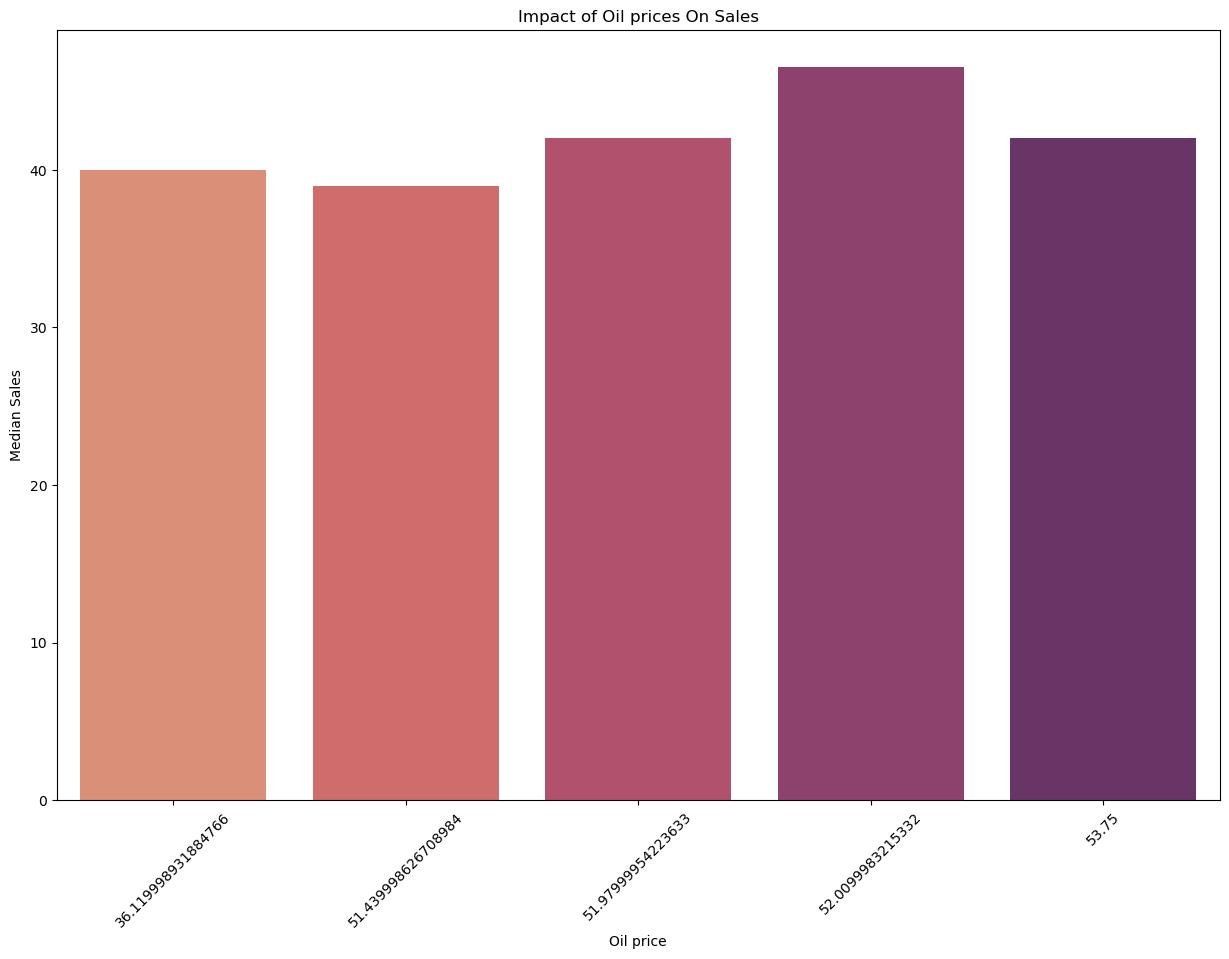

In [276]:
 # Check the effect of oil prices on sales  
oil_sales = oil_train_df.groupby(by="dcoilwtico")["sales"].median().sort_values(ascending=False).head(5)
# Convert oil_sales to DataFrame
oil_sales_df = pd.DataFrame(oil_sales).sort_values(by="sales", ascending=False)

# Plotting
sns.barplot(data=oil_sales_df,x=oil_sales_df.index, y="sales",palette="flare")
plt.title("Impact of Oil prices On Sales")
plt.xlabel("Oil price")
plt.ylabel("Median Sales")
plt.xticks(rotation=45)
plt.show()

### 7.What analysis can we get from the date and its extractable features?

1. Seasonality Analysis: Identify monthly or weekly patterns to understand cyclical trends in the data, such as higher sales during specific months or days of the week.

2. Trend Analysis: Examine long-term trends by year or month to track overall growth or decline, and to spot periodic changes in the data.

3. Holiday and Event Impact: Assess how holidays and special events influence the data, revealing spikes or drops in metrics like sales.

4. Time-based Segmentation: Segment data by various time frames (quarters, hours) to uncover patterns, trends, and performance metrics specific to each segment. 

5. Growth Rate Calculation
Year-over-Year (YoY) Growth: Calculate and compare the growth rate of key metrics year-over-year.
Month-over-Month (MoM) Growth: Calculate the growth rate from one month to the next.



### 8.Which product family and stores did the promotions affect

### 9.What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

Mean Squared Error (MSE)
MSE calculates the average of the squares of the differences between predicted and actual values. Squaring these differences means that larger errors have a disproportionately larger effect on the metric. This makes MSE sensitive to outliers and emphasizes larger errors.

Root Mean Squared Error (RMSE)
RMSE is the square root of MSE. By taking the square root, RMSE translates the squared differences back into the same units as the original data, making it more interpretable. RMSE retains the sensitivity to larger errors due to the squaring process but is more intuitive to understand in terms of the original data scale.

Root Mean Squared Logarithmic Error (RMSLE)
RMSLE takes the logarithm of predicted and actual values before calculating the squared differences. This approach diminishes the impact of large differences and makes the metric more robust to a wide range of values. 

Mean Absolute Error (MAE)
MAE calculates the average of the absolute differences between predicted and actual values. Unlike MSE and RMSE, MAE does not square the errors, treating all differences equally regardless of their magnitude. This makes MAE less sensitive to outliers and gives a straightforward measure of average error.

Why is MAE often greater than MSE, RMSE, and RMSLE?
Sensitivity to Error Magnitude:

MSE and RMSE amplify larger errors because they square the differences. This can lead to smaller values compared to MAE when considering large discrepancies.
RMSLE, by using logarithms, reduces the influence of large errors, which can result in smaller values compared to MAE.
Error Treatment:

MAE treats each error equally by using absolute differences. This equal treatment means that MAE does not disproportionately penalize larger errors, often resulting in higher values compared to the other metrics which downplay smaller errors.


### 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [277]:
# copy the final train data
copy_train_df = final_train_data.copy()
# Convert the index to a PeriodIndex with monthly frequency
copy_train_df.index = pd.PeriodIndex(copy_train_df.index, freq='M')

# Extract the last day of each month
last_day_of_month = copy_train_df.index.to_timestamp(how='end')

# Filter sales data for the 15th and last days of the month
payment_dates_sales = copy_train_df[(copy_train_df['day_of_month'] == 15) | (copy_train_df["day_of_month"] == last_day_of_month.day)]

# Calculate average sales on payment dates
avg_sales_on_payment_dates = payment_dates_sales['sales'].mean().round(2)

# Calculate average sales on other days
other_days_sales = copy_train_df[~((copy_train_df['day_of_month'] == 15) | (copy_train_df["day_of_month"] == last_day_of_month.day))]

# Calculate average sales on other days
avg_sales_other_days = other_days_sales['sales'].mean().round(2)

# Print the average sales on payment dates and other days
print("Average sales on payment dates:", avg_sales_on_payment_dates)
print("Average sales on other days:", avg_sales_other_days)

Average sales on payment dates: 362.49
Average sales on other days: 356.54


#### Hypothesis Testing
### `Hypothesis`
`Null:` There is no significant relationship between the promotional status of products and the sales numbers within Corporation Favorita's stores

`Alternative:` There is a significant relationship between promotional status of products and the sales numbers within Corporation Favorita's stores

In [278]:
# Extract the relevant variables for the hypothesis test
promo_sales = final_train_data[final_train_data['onpromotion'] >= 1]['sales']
non_promo_sales = final_train_data[final_train_data['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): There is no significant relationship between sales levels and products promotions at Corporation Favorita.")
print("Alternative Hypothesis (H1): There is a statistically significant relationship between sales levels and products promotions at Corporation Favorita.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis: There is no significant relationship between sales levels and products promotions at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between sales levels and products promotions at Corporation Favorita.")

Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): There is no significant relationship between sales levels and products promotions at Corporation Favorita.
Alternative Hypothesis (H1): There is a statistically significant relationship between sales levels and products promotions at Corporation Favorita.
--------------------------------------------------
Test Statistic: 665.4144504427975
P-value: 0.0
Reject the null hypothesis: There is no significant relationship between sales levels and products promotions at Corporation Favorita.


Conclusion

Based on the results of the hypothesis testing, we have a test statistic of 665.414 and a p-value of 0.0. Given the extremely low p-value, which is well below the typical significance level (e.g., 0.05), we reject the null hypothesis. This indicates that there is a statistically significant relationship between sales levels and product promotions at Corporation Favorita. Therefore, promotional activities are associated with changes in sales levels, suggesting that promotions effectively influence sales performance.








#### Data Preparation

In [279]:
#   Differencing 
final_train_data["sales_diff"] =final_train_data["sales"] - final_train_data["sales"].shift(1)
final_train_data.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter,sales_diff
date,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,1,1,NaN
2013-01-01,1,BABY CARE,0.00,0.00,January,1,2013,1,Tuesday,1,1,0.00
2013-01-01,1,BEAUTY,0.00,0.00,January,1,2013,1,Tuesday,1,1,0.00
2013-01-01,1,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,1,1,0.00
2013-01-01,1,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,1,1,0.00


In [280]:
# check for missing values
final_train_data.isna().sum()

store_nbr       0
family          0
sales           0
onpromotion     0
month_name      0
month           0
year            0
day             0
day_name        0
day_of_month    0
quarter         0
sales_diff      1
dtype: int64

In [281]:
#Differencing
# group by sales date
differenced_df = final_train_data.groupby(final_train_data.index)["sales_diff"].sum().reset_index()
differenced_df.set_index("date",inplace=True)
differenced_df

,sales_diff
date,
2013-01-01,0.00
2013-01-02,29.21
2013-01-03,-4.21
2013-01-04,-14.00
2013-01-05,17.36
...,...
2017-08-11,9.48
2017-08-12,-6.97
2017-08-13,3.14


#### Check for stationarity after differencing

<Axes: title={'center': 'Sales after differencing'}, xlabel='date'>

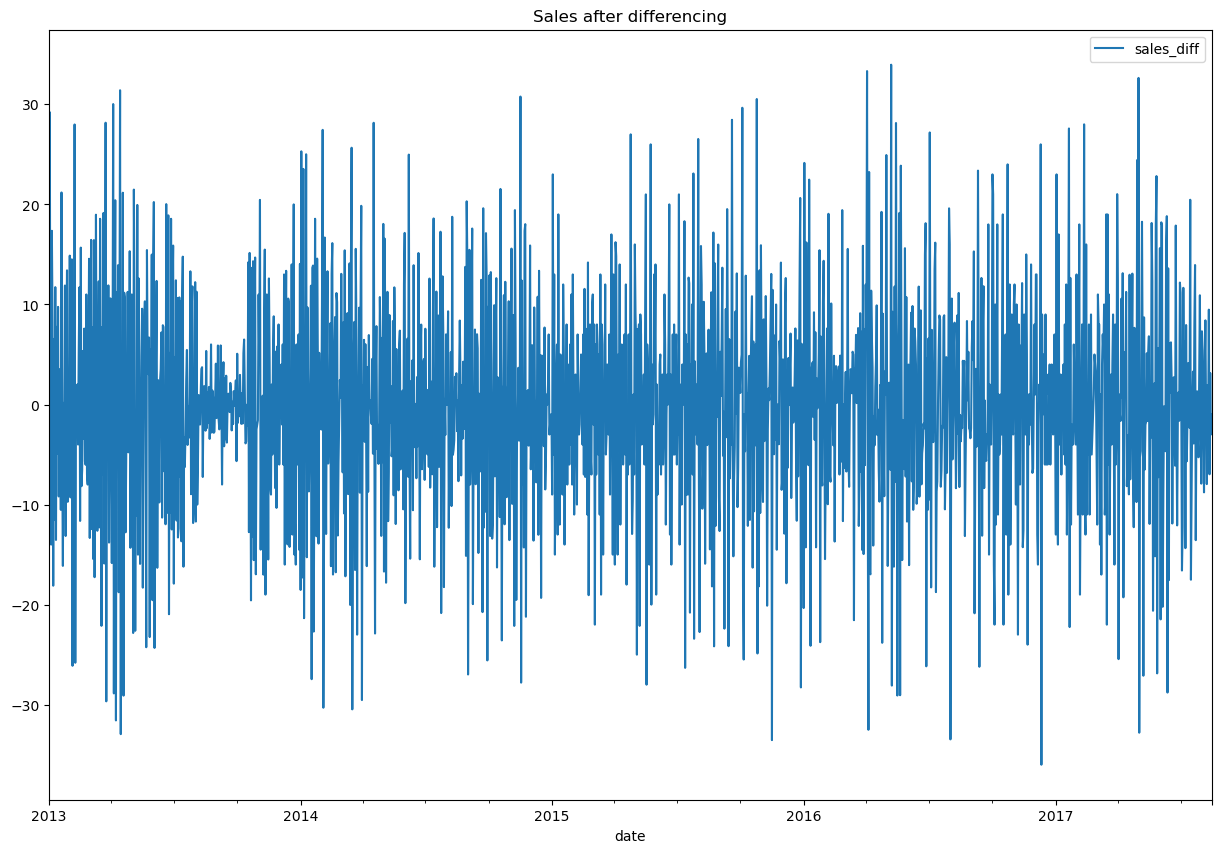

In [282]:
differenced_df.plot(title="Sales after differencing")

In [283]:
# Use Adfuller to check for stationarity
adftest = adfuller(differenced_df["sales_diff"])
print(f"ADF statistics: {adftest[0]}")
print(f"p-value: {adftest[1]}")
print(f"Critical values: {adftest[4]}")

if adftest[1] > 0.05:
    print("The series is non-stationary")
else:
    print("The series is stationary")

ADF statistics: -13.806449914863022
p-value: 8.384796586673739e-26
Critical values: {'1%': -3.43427885313169, '5%': -2.863275365507293, '10%': -2.5676938662645394}
The series is stationary


#### Rolling Statistics

In [284]:
# Add rolling mean with a 7-day window
final_train_data["moving_average_sales"] = final_train_data["sales"].rolling(window=30).mean()
final_train_data

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter,sales_diff,moving_average_sales
date,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,1,1,NaN,NaN
2013-01-01,1,BABY CARE,0.00,0.00,January,1,2013,1,Tuesday,1,1,0.00,NaN
2013-01-01,1,BEAUTY,0.00,0.00,January,1,2013,1,Tuesday,1,1,0.00,NaN
2013-01-01,1,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,1,1,0.00,NaN
2013-01-01,1,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,1,1,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-25,9,POULTRY,0.00,0.00,December,12,2016,6,Sunday,25,4,0.00,0.00
2016-12-25,9,PREPARED FOODS,0.00,0.00,December,12,2016,6,Sunday,25,4,0.00,0.00
2016-12-25,9,PRODUCE,0.00,0.00,December,12,2016,6,Sunday,25,4,0.00,0.00


# Feature Enginering

In [285]:
def sample_data(df: pd.DataFrame, size: float):
    """"
    Randomly samples data from the entire training dataset

    parameters: 
    df: pd.DataFrame, the input dataframe to be sampled from
    size: float, the proportion of the number of rows to sample

    returns:
    pd.DataFrame, the sampled dataframe
    """
    # calculate the number of rows to sample
    sample_size = int(size * len(df))
    # randomly sample the data
    sampled_data = df.sample(n=sample_size, random_state=42)
    return sampled_data

In [286]:
# call the the sample_data function to randomly sample 40% of data for training
sampled_data = sample_data(final_train_data,0.2)
# view the first five rows
sampled_data

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter,sales_diff,moving_average_sales
date,,,,,,,,,,,,,
2015-01-05,3,LAWN AND GARDEN,8.00,0.00,January,1,2015,0,Monday,5,1,8.00,756.36
2015-01-03,49,AUTOMOTIVE,10.00,0.00,January,1,2015,5,Saturday,3,1,-25.23,891.24
2017-04-24,13,LINGERIE,5.00,0.00,April,4,2017,0,Monday,24,2,5.00,224.34
2013-02-05,21,BEAUTY,0.00,0.00,February,2,2013,1,Tuesday,5,1,0.00,0.00
2013-09-18,46,HOME AND KITCHEN I,0.00,0.00,September,9,2013,2,Wednesday,18,3,-3.00,357.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-10,54,BABY CARE,0.00,0.00,November,11,2013,6,Sunday,10,4,-8.00,0.27
2014-04-16,15,DELI,162.00,0.00,April,4,2014,2,Wednesday,16,2,-183.00,92.11
2014-02-21,34,HOME AND KITCHEN I,0.00,0.00,February,2,2014,4,Friday,21,1,-2.00,295.95


In [287]:
# group by sales date
sum_of_sales = final_train_data.groupby(final_train_data.index)["moving_average_sales"].sum().reset_index()
sum_of_sales.set_index("date",inplace=True)
sum_of_sales

,moving_average_sales
date,
2013-01-01,2511.62
2013-01-02,491767.54
2013-01-03,362872.90
2013-01-04,355148.56
2013-01-05,475988.21
...,...
2017-08-11,825387.79
2017-08-12,792514.22
2017-08-13,865181.02


In [288]:
# check for Null Values
final_train_data.isna().sum()

store_nbr                0
family                   0
sales                    0
onpromotion              0
month_name               0
month                    0
year                     0
day                      0
day_name                 0
day_of_month             0
quarter                  0
sales_diff               1
moving_average_sales    29
dtype: int64

In [289]:
relevant_features = ["store_nbr","onpromotion","family","sales","day","sales_diff","moving_average_sales"]
training_data = sampled_data[relevant_features]
training_data

,store_nbr,onpromotion,family,sales,day,sales_diff,moving_average_sales
date,,,,,,,
2015-01-05,3,0.00,LAWN AND GARDEN,8.00,0,8.00,756.36
2015-01-03,49,0.00,AUTOMOTIVE,10.00,5,-25.23,891.24
2017-04-24,13,0.00,LINGERIE,5.00,0,5.00,224.34
2013-02-05,21,0.00,BEAUTY,0.00,1,0.00,0.00
2013-09-18,46,0.00,HOME AND KITCHEN I,0.00,2,-3.00,357.59
...,...,...,...,...,...,...,...
2013-11-10,54,0.00,BABY CARE,0.00,6,-8.00,0.27
2014-04-16,15,0.00,DELI,162.00,2,-183.00,92.11
2014-02-21,34,0.00,HOME AND KITCHEN I,0.00,4,-2.00,295.95


In [290]:
# check for Null Values
final_train_data.isna().sum()

store_nbr                0
family                   0
sales                    0
onpromotion              0
month_name               0
month                    0
year                     0
day                      0
day_name                 0
day_of_month             0
quarter                  0
sales_diff               1
moving_average_sales    29
dtype: int64

In [291]:
# Drop The Null Values
final_train_data.dropna(inplace=True)
# confirm changes
final_train_data.isna().sum()

store_nbr               0
family                  0
sales                   0
onpromotion             0
month_name              0
month                   0
year                    0
day                     0
day_name                0
day_of_month            0
quarter                 0
sales_diff              0
moving_average_sales    0
dtype: int64

In [292]:
def sample_data(df: pd.DataFrame, size: float):
    """"
    Randomly samples data from the entire training dataset

    parameters: 
    df: pd.DataFrame, the input dataframe to be sampled from
    size: float, the proportion of the number of rows to sample

    returns:
    pd.DataFrame, the sampled dataframe
    """
    # calculate the number of rows to sample
    sample_size = int(size * len(df))
    # randomly sample the data
    sampled_data = df.sample(n=sample_size, random_state=42)
    return sampled_data

In [293]:
# call the the sample_data function to randomly sample 40% of data for training
sampled_data = sample_data(final_train_data,0.2)
# view the first five rows
sampled_data

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter,sales_diff,moving_average_sales
date,,,,,,,,,,,,,
2015-01-12,47,FROZEN FOODS,302.70,3.00,January,1,2015,0,Monday,12,1,-44.30,400.85
2015-08-08,4,FROZEN FOODS,147.00,1.00,August,8,2015,5,Saturday,8,3,-11.00,257.18
2015-02-17,44,LAWN AND GARDEN,14.00,0.00,February,2,2015,1,Tuesday,17,1,14.00,866.29
2013-08-24,12,"LIQUOR,WINE,BEER",57.00,0.00,August,8,2013,5,Saturday,24,3,31.00,164.85
2016-06-08,45,SEAFOOD,83.93,2.00,June,6,2016,2,Wednesday,8,2,77.93,1144.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-14,41,SEAFOOD,5.74,0.00,June,6,2017,2,Wednesday,14,2,4.74,435.40
2015-01-11,50,HARDWARE,0.00,0.00,January,1,2015,6,Sunday,11,1,-38.00,615.35
2014-03-14,8,POULTRY,782.31,0.00,March,3,2014,4,Friday,14,1,757.31,461.92


### Feature Scaling and Encoding

In [294]:
relevant_features = ["store_nbr","onpromotion","family","sales","day","sales_diff","moving_average_sales"]
training_data = sampled_data[relevant_features]
training_data

,store_nbr,onpromotion,family,sales,day,sales_diff,moving_average_sales
date,,,,,,,
2015-01-12,47,3.00,FROZEN FOODS,302.70,0,-44.30,400.85
2015-08-08,4,1.00,FROZEN FOODS,147.00,5,-11.00,257.18
2015-02-17,44,0.00,LAWN AND GARDEN,14.00,1,14.00,866.29
2013-08-24,12,0.00,"LIQUOR,WINE,BEER",57.00,5,31.00,164.85
2016-06-08,45,2.00,SEAFOOD,83.93,2,77.93,1144.28
...,...,...,...,...,...,...,...
2017-06-14,41,0.00,SEAFOOD,5.74,2,4.74,435.40
2015-01-11,50,0.00,HARDWARE,0.00,6,-38.00,615.35
2014-03-14,8,0.00,POULTRY,782.31,4,757.31,461.92


#### Data Processing

In [295]:
# define a function to preprocess the data for modelling
def feature_preprocessor(df: pd.DataFrame):
    # separate categorical and numerical columns
    categorical_cols = df.select_dtypes("object").columns
    numerical_cols = df.select_dtypes("number").columns

    # save a copy of the date index
    original_date = df.index.copy()

    # Define the preprocessor to hanle all the preprocessing steps with a column transformer
    preprocessor = ColumnTransformer(
        [("scaler",MinMaxScaler(),numerical_cols),
         ("encoder",OneHotEncoder(handle_unknown="ignore",sparse_output=False,categories="auto"),categorical_cols)],                                    
         remainder="passthrough"
    )
                
    # fit the preprocessor to the data while dropping the index column
    preprocessor.fit(df)

    # transform the data using the preprocessor
    transformed_data = preprocessor.transform(df)
    
    #Get the various prepocessors
    scaler = preprocessor.named_transformers_["scaler"]
    encoder = preprocessor.named_transformers_["encoder"]

    # Access the feature names
    scaled_feature_name = scaler.get_feature_names_out(input_features=numerical_cols)
    encoded_feature_name = encoder.get_feature_names_out(input_features=categorical_cols)

    # Get a list of all feature names
    feature_names = scaled_feature_name.tolist() + encoded_feature_name.tolist()
    
    # convert the transformed data to a dataframe
    transformed_df = pd.DataFrame(transformed_data,columns=feature_names)
    
    # add the original date column back to the dataframe
    transformed_df.index = original_date

    # reset and sort the index
    transformed_df.sort_index().reset_index()
    
    # return the preprocessed dataframe, preprocessor and the scaler to be used for denormalize the encoded sales
    return transformed_df, preprocessor, scaler,encoder
    

In [296]:
# Apply the function to the train_df
preprocessed_train_df ,preprocessor,scaler,_= feature_preprocessor(training_data)

# view the first five rows
preprocessed_train_df

,store_nbr,onpromotion,sales,day,sales_diff,moving_average_sales,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2015-01-12,0.87,0.00,0.00,0.00,0.49,0.09,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2015-08-08,0.06,0.00,0.00,0.83,0.49,0.06,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2015-02-17,0.81,0.00,0.00,0.17,0.49,0.19,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2013-08-24,0.21,0.00,0.00,0.83,0.49,0.04,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-06-08,0.83,0.00,0.00,0.33,0.49,0.25,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-14,0.75,0.00,0.00,0.33,0.49,0.10,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2015-01-11,0.92,0.00,0.00,1.00,0.49,0.14,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2014-03-14,0.13,0.00,0.01,0.67,0.50,0.10,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


### Train test Split

In [297]:
train_size = int(0.8 * len(preprocessed_train_df))

# split the data into train and test
train_data = preprocessed_train_df[:train_size]
test_data = preprocessed_train_df[train_size:]

## Data Modeling

In [298]:
# target and feature variable for training and testing
X_train = train_data.drop('sales', axis=1)
y_train = train_data['sales'] 

X_test = test_data .drop('sales', axis=1)  
y_test = test_data ['sales']

In [299]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

## Model 1. Linear Regression

In [300]:
# Linear Regression Model
lnr_reg = LinearRegression()
lnr_reg.fit(X_train, y_train)
lnr_pred = lnr_reg.predict(X_test)

# Calculate Mean Squared Error (MSE)
lnr_mse = mean_squared_error(y_test, lnr_pred)

# Calculate Mean Absolute Error (MAE)
lnr_mae = mean_absolute_error(y_test, lnr_pred)

# Apply the absolute value function y_eval and lnr_pred
y_test_abs = abs(y_test)
lnr_pred_abs = abs(lnr_pred)

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
lnr_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, lnr_pred_abs))

# Create a DataFrame to store results for LinearRegression
lnr_results = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lnr_rmsle],
                            'RMSE': [np.sqrt(lnr_mse)],
                            'MSE': [lnr_mse],
                            'MAE': [lnr_mae]})

lnr_results

,Model,RMSLE,RMSE,MSE,MAE
0,Linear Regression,0.01,0.01,0.00,0.00


## Model 2. ARIMA (AutoRegressive Integrated Moving Average)

In [302]:


# Define ARIMA order parameters
p, d, q = 1, 0, 0

# Instantiate and fit ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_pred = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_test) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_test, arima_pred)
arima_rmse = np.sqrt(arima_mse)

# Calculate evaluation metrics with absolute values
arima_mae = mean_absolute_error(y_test, arima_pred)
arima_rmsle = np.sqrt(mean_squared_log_error(abs(y_test), abs(arima_pred)))

# Create a DataFrame to store results for ARIMA
arima_results = pd.DataFrame({
    'Model': ['ARIMA'],
    'RMSLE': [arima_rmsle],
    'RMSE': [arima_rmse],
    'MSE': [arima_mse],
    'MAE': [arima_mae]
}).round(2)

arima_results

,Model,RMSLE,RMSE,MSE,MAE
0,ARIMA,0.01,0.01,0.00,0.01


## Model 3. Random Forest Regression

In [303]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Calculate metrics
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

# Apply the absolute value function to both y_test and rf_predictions
y_test_abs = abs(y_test)
rf_pred_abs = abs(rf_pred)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, rf_pred_abs))

# Create a DataFrame to store results for Random Forest
rf_results = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]})

rf_results

,Model,RMSLE,RMSE,MSE,MAE
0,Random Forest,0.00,0.00,0.00,0.00


- RMSLE (Root Mean Squared Logarithmic Error) quantifies the ratio between the logarithm of predicted and actual values, making it beneficial for target variables with wide value ranges.
A Lower RMSLE values suggest superior model performance. This metric equally penalizes underestimation and overestimation, making it suitable for skewed distributions.

- RMSE (Root Mean Squared Error) calculates the average magnitude of errors between predicted and actual values, represented as the square root of mean squared differences.
A Lower RMSE values signify better model performance. This metric gives higher weight to larger errors and can be influenced by outliers.

- MSE (Mean Squared Error) determines the mean of squared deviations between predicted and actual values, offering insight into the average squared difference.
A Lower MSE values indicate improved model performance. Being in the same unit as the squared target variable, MSE facilitates straightforward interpretation.

- MAE (Mean Absolute Error) represents the mean of absolute differences between predicted and actual values, providing an average error magnitude disregarding direction.
A Lower MAE values suggest superior model performance. MAE exhibits robustness against outliers compared to RMSE, making it preferable in outlier-prone scenarios.

In summary, after optimizing its hyperparameters, the Random Forest model exhibits enhanced predictive capability when compared to its initial setup. By effectively capturing the intricate relationships between features and sales, it delivers more precise predictions when evaluated against the dataset.

### Training the Model

In [ ]:
# Print the results dataframes
print("Results for Linear Regression:\n", lnr_results)
print("\nResults for ARIMA:\n", arima_results)
print("\nResults for Random Forest:\n", rf_results)

Results for Linear Regression:
                Model  RMSLE  RMSE  MSE  MAE
0  Linear Regression   0.27  0.84 0.71 0.37

Results for ARIMA:
    Model  RMSLE  RMSE  MSE  MAE
0  ARIMA   0.45  1.09 1.19 0.50

Results for Random Forest:
            Model  RMSLE  RMSE  MSE  MAE
0  Random Forest   0.24  0.74 0.54 0.26


According to the outcomes, the Random Forest Regression model secured the lowest RMSLE score of 0.23, surpassing the other two models. This suggests its superior ability to predict logarithmic errors. Furthermore, it demonstrated competitive performance in terms of RMSE, MSE, and MAE values, further affirming its effectiveness in predictive accuracy.

In [ ]:
# Create and fit the Random Forest model
best_rf_model = RandomForestRegressor()
best_rf_model.fit(X_train, y_train)

# Access feature importances
feature_importances = best_rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Print the top features
print("Top Features:")
for i in sorted_idx[:5]:
    print(f"{X_train.columns[i]}: {feature_importances[i]}")

# Cross-Validation and Evaluation
cv_results = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_results)

# Print cross-validation results
print("\nCross-Validation Results:")
for i, score in enumerate(cv_rmse_scores):
    print(f"Fold {i + 1}: RMSE - {score}")

# Retrain the model on the entire training set
best_rf_model.fit(X_train, y_train)

# Make predictions on the evaluation set
best_rf_pred = best_rf_model.predict(X_test)

# Evaluate the model on the evaluation set
best_rf_mse = mean_squared_error(y_test, best_rf_pred)
best_rf_rmse = np.sqrt(best_rf_mse)

# Print final evaluation results
print("\nFinal Evaluation Results:")
print(f"RMSE on Evaluation Set: {best_rf_rmse}")

# Save the model for deployment
joblib.dump(best_rf_model, 'random_forest_model.joblib')


Top Features:
onpromotion: 0.2970057427417593
transactions: 0.2538010839202844
family_GROCERY: 0.18246220544863143
dcoilwtico: 0.06420554753636808
day: 0.03946602508177853

Cross-Validation Results:
Fold 1: RMSE - 0.6414342194997077
Fold 2: RMSE - 0.5954709738198807
Fold 3: RMSE - 0.6379902568520643
Fold 4: RMSE - 0.9528312773061426
Fold 5: RMSE - 0.8637986608420823

Final Evaluation Results:
RMSE on Evaluation Set: 0.7489177288891505


['random_forest_model.joblib']

### Save the Best RandomForest Model

In [ ]:
# Define the key components
key_components = {
    'model': best_rf_model, 
    'best_score': best_rf_rmse
}

# Save the key components in a file using pickle
with open('best_rf_model_components.pkl', 'wb') as file:
    pickle.dump(key_components, file)
